# Tutorial for Latent Diffusion Model

This notebook provides a tutorial on the Latent Diffusion Model (LDM). It demonstrates how LDMs can be designed, trained, and used for data generation. The models used in this notebook are simplified and not suitable for general-purpose use. However, I hope this tutorial helps you understand the internal workings of LDMs.

For simplicity, the following adjustments are applied:
- The dataset used is the Swiss roll dataset, which is two-dimensional.
- An Autoencoder (AE) is used instead of a Variational Autoencoder (VAE).
- A linear model is used for the diffusion process, rather than the U-Net architecture commonly used for image generation tasks.

In [35]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from PIL import Image as image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset

The dataset used in this tutorial is the two-dimensional Swiss roll dataset. This dataset is chosen because it is interesting and easy to visualize, making it suitable for demonstrating how the model works. The goal is to generate latent variables in a one-dimensional space and decode them to reconstruct the two-dimensional Swiss roll data.

In [3]:
def plot(dat) :
    if type(dat) is torch.Tensor:
        dat = dat.detach().cpu().numpy()
    plt.figure(figsize = (5, 5))
    plt.scatter(*dat.T)
    plt.show()

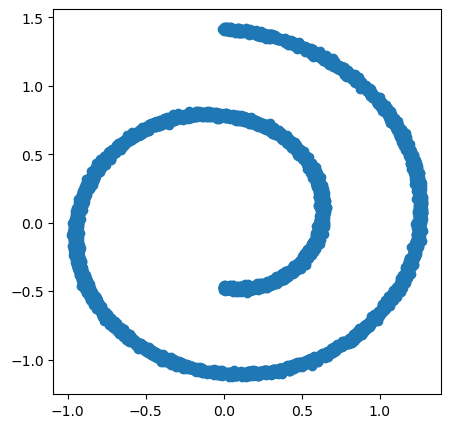

In [4]:
sr, _ = make_swiss_roll(10 ** 4, noise = 0.1) # Original data
sr = (sr[:, [0,2]] / 10).astype(np.float32) # Scaling
plot(sr)

In [5]:
data_loader = DataLoader(sr, batch_size = 256, shuffle=True)

# Training the Autoencoder (AE)

The Autoencoder (AE) is trained to compress the dimensionality of the data. While Latent Diffusion Models (LDMs) typically use Variational Autoencoders (VAEs) to address the issue of high-variance latent spaces, we use an AE in this tutorial. This choice is made because the dataset is simple and scaled, so we assume that the latent space will not exhibit significant variance.

Furthermore, the encoder and decoder in the AE consist of linear layers with ReLU activations. The only parameters we need to decide are the number of layers and the size of each layer.

In [6]:
class SimpleAE(nn.Module) :
    def __init__(self, dim, latent_dim, hidden_layer_size=128, num_hidden_layer=3):
        super(SimpleAE, self).__init__()
        # Encoder
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Linear(dim, hidden_layer_size))
        self.encoder.append(nn.ReLU())
        for _ in range(num_hidden_layer):
            self.encoder.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            self.encoder.append(nn.ReLU())
        self.encoder.append(nn.Linear(hidden_layer_size, latent_dim))
        
        # Decoder
        self.decoder = nn.ModuleList()
        self.decoder.append(nn.Linear(latent_dim, hidden_layer_size))
        self.decoder.append(nn.ReLU())
        for _ in range(num_hidden_layer):
            self.decoder.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Linear(hidden_layer_size, dim))
        
    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x
    
    def decode(self, z):
        for layer in self.decoder:
            z = layer(z)
        return z
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [7]:
ae = SimpleAE(dim=2, latent_dim=1, hidden_layer_size=256, num_hidden_layer=3).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr= 1e-4)

In [8]:
def train(model, data_loader, criterion, optimizer, num_epochs, file_name='ae'):
    model.train()
    best_loss = float('inf')
    
    for epoch in range(num_epochs) :
        epoch_loss = 0.0
        
        for batch in data_loader:
            optimizer.zero_grad()
            x = batch.to(device)
            x_hat = model(x)
            loss = criterion(x, x_hat)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(x) / len(data_loader.dataset)
            
        log = f"Loss at epoch {epoch}: {epoch_loss :.4f}"
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), file_name + '.pth')
            log += " --> Best model ever"
            print(log)

In [9]:
#train(ae, data_loader, nn.functional.mse_loss, optimizer, 5000)

In [9]:
check_points = torch.load("ae" + ".pth", map_location=device)
ae.load_state_dict(check_points)
ae.eval()
for param in ae.parameters():
    param.requires_grad = False

Once the AE is trained, we can examine the reconstructed data and the distribution of the latent variables.

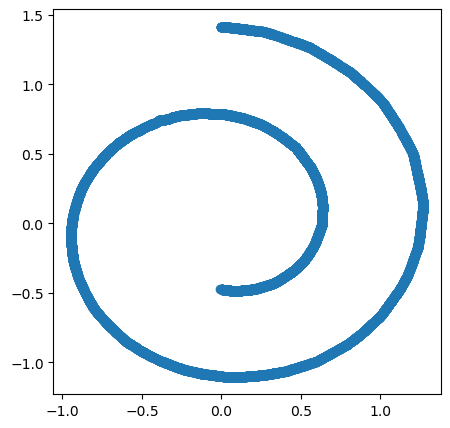

In [42]:
outputs = ae(torch.tensor(sr).to(device))
plot(outputs)

<Axes: ylabel='Density'>

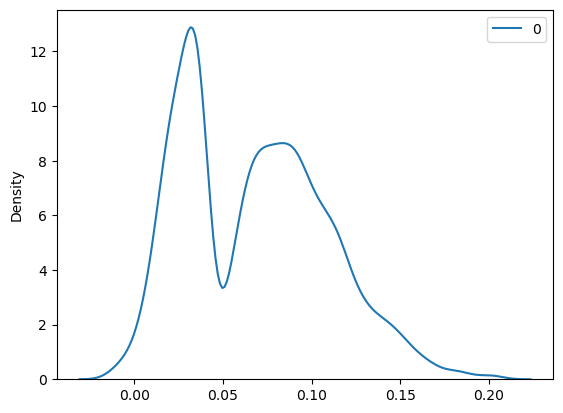

In [43]:
latents = ae.encode(torch.tensor(sr).to(device))
sns.kdeplot(latents.detach().cpu().numpy())

Since we are using an AE, the latent variables can be directly used for training the LDM, rather than encoding the data during training. To ensure efficient training of the LDM, the latent variables should be normalized.

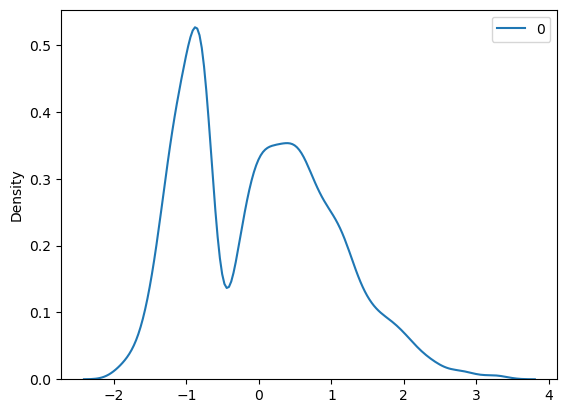

In [11]:
# Normalization for the training LDM
latents_mean = latents.mean()
latents_std = latents.std()
latents = (latents - latents_mean) / latents_std 
sns.kdeplot(latents.detach().cpu().numpy())
latents_loader = DataLoader(latents, batch_size = 256, shuffle = True) # DataLoader with the latent

# Latent Diffusion Model

With the configuration so far, the LDM is trained using the exact same process as DDPMs. The only difference is that the DataLoader contains the encoded latent variables instead of the original data. The code below is identical to the one used for DDPMs.

In [12]:
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

In [13]:
# Set T
T = 100
timesteps = range(T)
betas = torch.linspace(start = 0.001, end = 0.2, steps = T).to(device)

# alphas
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim = 0)

# Forward process
def forward(x0, t, eps = None) :
    alpha_t_bar = extract(alpha_bars, t, x0.shape).to(device)
    
    if eps is None :
        eps = torch.randn_like(x0).to(device)
    
    noisy = alpha_t_bar.sqrt() * x0 + (1 - alpha_t_bar).sqrt() * eps
    return noisy

# Reverse process
def reverse(x, t, model) :
    return model(x, t)

In [25]:
#Sampling
@torch.no_grad()
def p_sample(x, t, model) :
    eps_hat = reverse(x, t, model)
    t = int(t[0].item())
    
    alpha_t = alphas[t]
    alpha_t_bar = alpha_bars[t]
    
    x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eps_hat)
    
    if t > 0 :
        z = torch.randn_like(x).to(x.device)
        beta_t = betas[t]
        
        prev_alpha_t_bar = alpha_bars[t - 1] if t > 1 else 1
        beta_tilde_t = ((1 - prev_alpha_t_bar) / (1 - alpha_t_bar)) * beta_t
        sigma_t = beta_tilde_t.sqrt()
        
        x = x + sigma_t * z 
        
    return x

@torch.no_grad()
def p_sample_loop(n_samples, model, only_last=True) :
    x_T = torch.randn(n_samples, 1).to(device)
    x = x_T
    n = x.size(0)
    if only_last == False:
        x_seq = [] # For making GIF files
        x_seq.append(x)
    
    for _, t in tqdm(enumerate( np.flip( timesteps ))) :
        t = x.new_full((n, ), t, dtype = torch.int).to(device)
        x = p_sample(x, t, model)
        if only_last == False:
            x_seq.append(x)
    
    if only_last:
        return x
    else:
        return x_seq

Since we are working with one-dimensional latent variables, a linear network is sufficient to estimate the noise instead of using a U-Net architecture. The linear network has the same structure as the encoder and decoder in the AE, consisting only of linear layers with ReLU activations.

For simplicity, the timestep is provided as a separate variable alongside the latent variable, rather than being embedded. Additionally, other components, such as the exponential moving average (EMA) technique, are not included. Due to this configuration, the model's convergence may be slower.

In [15]:
# Network
class LinearNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layer_size=128, num_hidden_layer=3):
        super(LinearNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, hidden_layer_size))
        for _ in range(num_hidden_layer):
            self.layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
        self.final = nn.Linear(hidden_layer_size, out_dim)
    
    def forward(self, x, t):
        x = torch.cat([x, t.unsqueeze(1)], dim=-1) # The timestep is concatenated with the latent variable, resulting in two-dimensional data
        for layer in self.layers:
            x = nn.functional.relu(layer(x))
        x = self.final(x)
        return x

In [16]:
def train(model, ema, data_loader, criterion, optimizer, num_epochs, file_name='dm'):
    model.train()
    best_loss = float('inf')
    
    for epoch in range(num_epochs) :
        epoch_loss = 0.0
        
        for batch in data_loader:
            optimizer.zero_grad()
            x0 = batch.to(device)
            n = len(x0)
            eps = torch.randn_like(x0).to(device)
            t = torch.randint(0, T, (n, )).to(device)

            noisy = forward(x0, t, eps).to(device)
            eps_hat = reverse(noisy, t, model).to(device)
            loss = criterion(eps, eps_hat)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(x0) / len(data_loader.dataset)
            
        log = f"Loss at epoch {epoch}: {epoch_loss :.4f}"
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), file_name + '.pth')
            log += " --> Best model ever"
            print(log)

In [17]:
dm = LinearNetwork(2, 1, 128, 3).to(device)
optimizer = torch.optim.Adam(dm.parameters(), lr= 1e-4)

In [288]:
#train(dm, ema, latents_loader, nn.functional.mse_loss, optimizer, 10000)

Loss at epoch 0: 0.2572 --> Best model ever
Loss at epoch 1: 0.2562 --> Best model ever
Loss at epoch 4: 0.2517 --> Best model ever
Loss at epoch 8: 0.2505 --> Best model ever
Loss at epoch 12: 0.2501 --> Best model ever
Loss at epoch 16: 0.2484 --> Best model ever
Loss at epoch 20: 0.2478 --> Best model ever
Loss at epoch 30: 0.2476 --> Best model ever
Loss at epoch 49: 0.2432 --> Best model ever
Loss at epoch 114: 0.2417 --> Best model ever
Loss at epoch 397: 0.2407 --> Best model ever
Loss at epoch 430: 0.2383 --> Best model ever
Loss at epoch 1516: 0.2381 --> Best model ever
Loss at epoch 1634: 0.2380 --> Best model ever
Loss at epoch 2554: 0.2379 --> Best model ever
Loss at epoch 2725: 0.2350 --> Best model ever
Loss at epoch 4686: 0.2342 --> Best model ever


In [20]:
check_points = torch.load("dm" + ".pth", map_location=device)
dm.load_state_dict(check_points)
dm.eval()

LinearNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1-3): 3 x Linear(in_features=128, out_features=128, bias=True)
  )
  (final): Linear(in_features=128, out_features=1, bias=True)
)

We can generate latent variables using the trained diffusion model.

100it [00:00, 391.87it/s]


<Axes: ylabel='Density'>

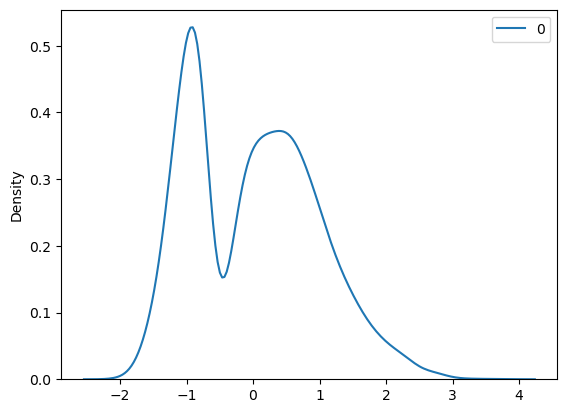

In [48]:
generated_latents = p_sample_loop(4000, dm)
sns.kdeplot(generated_latents.detach().cpu().numpy())

The data can be reconstructed by passing the latent variables through the trained decoder. As shown in the plot, the reconstructed data is not perfect, but most points lie on the data distribution.

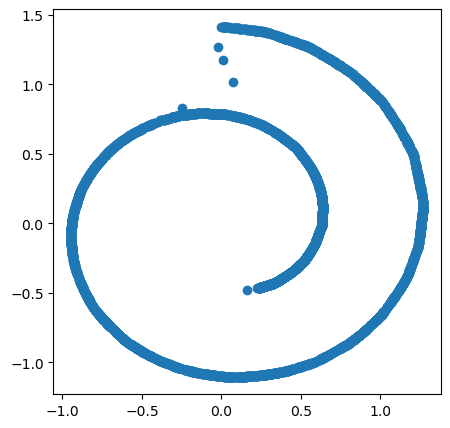

In [49]:
generated_latents = (generated_latents * latents_std) + latents_mean # Invert the normalization to decode the generated latent variables
x_hat = ae.decode(generated_latents) # The reconstructed data
plot(x_hat.detach().cpu().numpy())

# Make GIF

The following process generates a GIF file that illustrates the generation process of the LDM.

In [50]:
generated_latents = p_sample_loop(4000, dm, False)

100it [00:00, 385.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.83it/s]


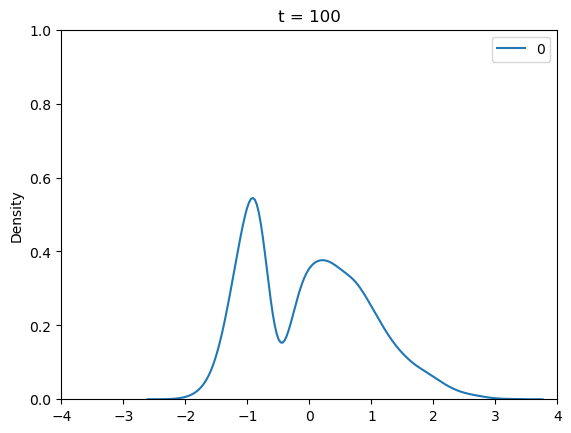

In [51]:
imgs = []
for i in tqdm(range(len(generated_latents))) :
    img_buf = io.BytesIO()
    plt.clf()
    plt.ylim(0, 1)
    plt.xlim(-4, 4)
    plt.title('t = ' + str(i))
    sns.kdeplot(generated_latents[i].detach().cpu().numpy())
    plt.savefig(img_buf, format='png')
    imgs.append(image.open(img_buf))
imgs[0].save("swiss_roll.gif", format='GIF', append_images=imgs,save_all=True, duration=1, loop=0)

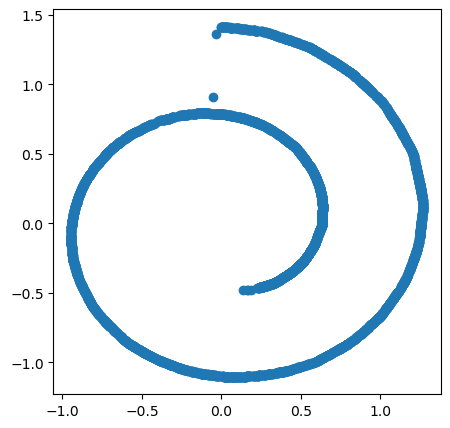

In [52]:
generated_latents_last = generated_latents[-1]
generated_latents_last = (generated_latents_last * latents_std) + latents_mean
x_hat = ae.decode(generated_latents_last)
plot(x_hat.detach().cpu().numpy())